# Numerical evaluation of root-finding, topological ordering, and edge pruning

Code by Jacqueline Maasch | April 2024

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
import warnings
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from dowhy import gcm
from dowhy.gcm.util.general import set_random_seed
from os import listdir
from os.path import isfile, join
import CausalDisco
from CausalDisco.analytics import (
    var_sortability,
    r2_sortability,
    snr_sortability,
    r2coeff,
    order_alignment
)

# Custom scripts.
#from root_id import RootID
import Root_Algo
import path_tracing
from edge_discovery import EdgeDiscovery

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


/Users/jmaasch/anaconda3/envs/icp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def plot_nx(adjacency_matrix,
            labels,
            figsize = (5,5),
            dpi = 75,
            node_size = 800,
            arrow_size = 10):

    '''
    Plot graph given adjacency matrix.
    '''
    
    g = nx.from_numpy_array(adjacency_matrix, create_using = nx.DiGraph)
    plt.figure(figsize = figsize, dpi = dpi)  
    nx.draw_circular(g, 
                     node_size = node_size, 
                     node_color = "pink",
                     labels = dict(zip(list(range(len(labels))), labels)), 
                     arrowsize = arrow_size,
                     with_labels = True)
    plt.show()
    plt.close()

In [3]:
def get_ci(results: list,
           z: float = 1.96,
           return_mean: bool = True) -> tuple:

    '''
    Default is 95% confidence interval.
    '''

    mean = np.mean(results)
    se = stats.sem(results)
    ci = [mean - (z * se), mean + (z * se)]
    if return_mean:
        return mean, ci
    return ci

In [4]:
# https://www.pywhy.org/dodiscover/dev/auto_examples/plot_pc_alg.html
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/modeling_gcm/customizing_model_assignment.html
class MyCustomModel(gcm.PredictionModel):
    def __init__(self, coefficient):
        self.coefficient = coefficient

    def fit(self, X, Y):
        # Nothing to fit here, since we know the ground truth.
        pass

    def predict(self, X):
        return self.coefficient * X

    def clone(self):
        # We don't really need this actually.
        return MyCustomModel(self.coefficient)

def sample_from_dag(G, n = 1000, scale = True):

    '''
    Sample data from DGP defined by networkx graph G.
    '''
    
    #nx.draw_shell(G, 
    #              node_color = "pink",
    #              node_size = 800, 
    #              arrowsize = 10,
    #              with_labels = True)
    #plt.show()
    #plt.close()

    # Define causal model.
    causal_model = gcm.ProbabilisticCausalModel(G)
    params = np.random.uniform(low = -1.2, high = 1.5, size = len(nodes))
    for node,p in zip(nodes,params):
        if node in root_idx:
            #causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.binom, p = p, n = 1))
            causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1))
        else:
            causal_model.set_causal_mechanism(
                    node,
                    gcm.AdditiveNoiseModel(
                        #prediction_model = gcm.ml.create_linear_regressor(),
                        prediction_model = MyCustomModel(1),
                        #noise_model = gcm.ScipyDistribution(stats.binom, p = p, n = 1),
                        noise_model = gcm.ScipyDistribution(stats.laplace, loc = p, scale = 1),
                    ),
                )

    # "Fit here would not really fit parameters, since we don't do anything in the fit method.
    # Here, we only need this to ensure that each FCM has the correct local hash (i.e., we
    # get an inconsistency error if we would modify the graph afterwards without updating
    # the FCMs). Having an empty data set is a small workaround, since all models are pre-defined."
    gcm.fit(causal_model, pd.DataFrame(columns = nodes))
    
    # Sample the observational data.
    data = gcm.draw_samples(causal_model, num_samples = n)

    # Columns are shuffled by DoWhy; put back in order w.r.t. order of adjacency matrix.
    data = data[nodes]
        
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
        
    return data

## Read data

In [5]:
# Erdos-Renyi graphs.
df_10n_10m = pd.read_csv("data/erdos_renyi/erdos_renyi_10n_10m.csv")

In [6]:
display(df_10n_10m.head(10))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Replicate
0,0,0,0,0,1,0,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,1,1,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,1,0,0,1
6,0,0,0,0,0,0,0,0,1,0,1
7,0,0,0,0,0,0,0,0,1,0,1
8,0,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,1


## Process data

In [7]:
# Extract adjacency matrices.
n = 10
df_10n_10m = df_10n_10m.drop(columns = "Replicate")
adj_matrices = [df_10n_10m[i:i+n].to_numpy() for i in range(0,df_10n_10m.shape[0],n)]

array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

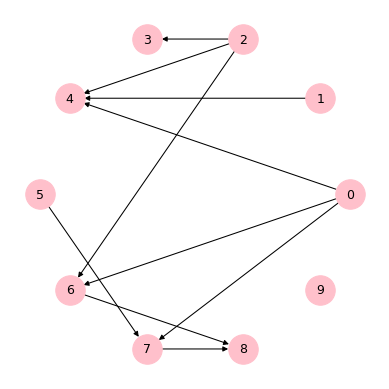

array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

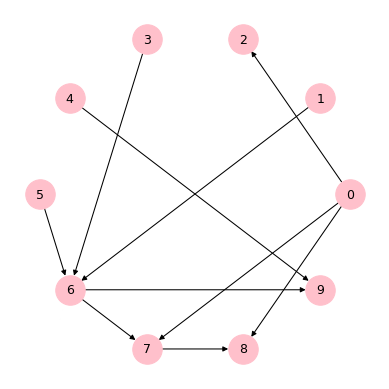

array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

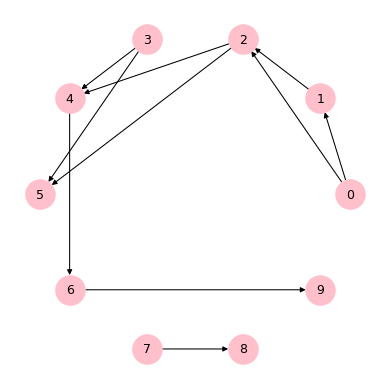

array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

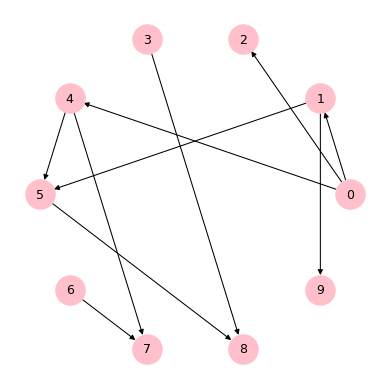

array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

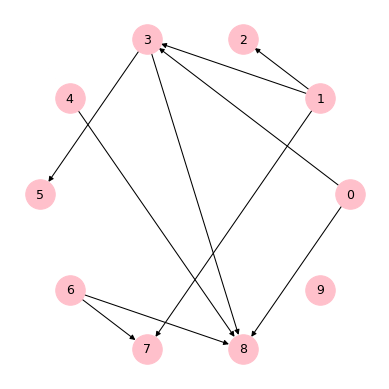

array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

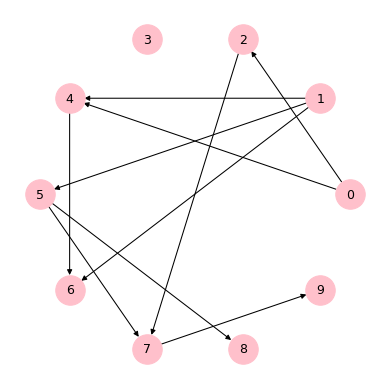

array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

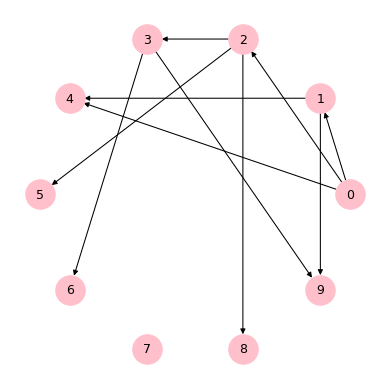

array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

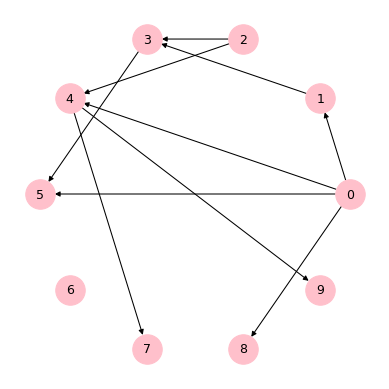

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

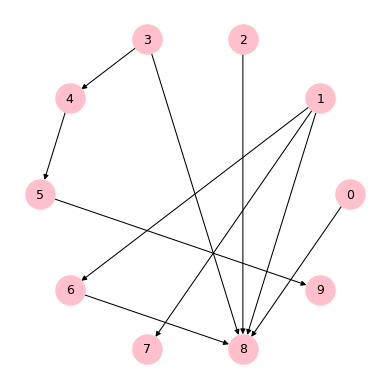

array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

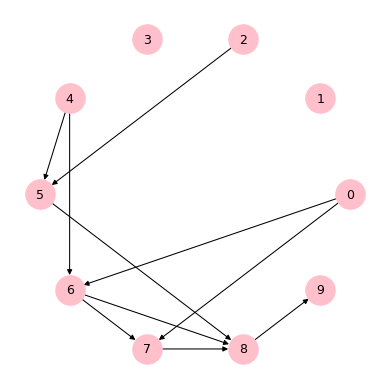

In [8]:
for adj in adj_matrices:
    display(adj)
    plot_nx(adj, labels = range(adj.shape[1]))

## Sample from distribution

In [9]:
%%capture
#set_random_seed(1234)

samples_500 = []
samples_1k = []
samples_5k = []
samples_10k = []
samples_20k = []
roots_true = []
graphs = []

samples_500_r2 = []
samples_1k_r2 = []
samples_5k_r2 = []
samples_10k_r2 = []
samples_20k_r2 = []

samples_500_var = []
samples_1k_var = []
samples_5k_var = []
samples_10k_var = []
samples_20k_var = []

for adj in adj_matrices:

    # Identify true roots from adjacency matrix.
    nodes = range(adj.shape[1])
    column_sums = adj.sum(axis = 0)
    root_idx = np.where(column_sums == 0)[0]
    roots_true.append(root_idx)

    # Construct graph from adjacency matrix.
    G = nx.from_numpy_array(adj, create_using = nx.DiGraph)
    node_map = dict(zip(range(adj.shape[1]), nodes))
    G = nx.relabel_nodes(G, node_map, copy = True)
    graphs.append(G)

    # Sample data.
    sample_500 = sample_from_dag(G, n = 500, scale = True)
    samples_500.append(sample_500)
    samples_500_r2.append(r2_sortability(X = sample_500, W = adj))
    samples_500_var.append(var_sortability(X = sample_500, W = adj))

    sample_1k = sample_from_dag(G, n = 1000, scale = True)
    samples_1k.append(sample_1k)
    samples_1k_r2.append(r2_sortability(X = sample_1k, W = adj))
    samples_1k_var.append(var_sortability(X = sample_1k, W = adj))

    sample_5k = sample_from_dag(G, n = 5000, scale = True)
    samples_5k.append(sample_5k)
    samples_5k_r2.append(r2_sortability(X = sample_5k, W = adj))
    samples_5k_var.append(var_sortability(X = sample_5k, W = adj))

    sample_10k = sample_from_dag(G, n = 10000, scale = True)
    samples_10k.append(sample_10k)
    samples_10k_r2.append(r2_sortability(X = sample_10k, W = adj))
    samples_10k_var.append(var_sortability(X = sample_10k, W = adj))
    
    sample_20k = sample_from_dag(G, n = 20000, scale = True)
    samples_20k.append(sample_20k)
    samples_20k_r2.append(r2_sortability(X = sample_20k, W = adj))
    samples_20k_var.append(var_sortability(X = sample_20k, W = adj))

In [10]:
len(adj_matrices)

In [11]:
r2_all = [samples_500_r2, samples_1k_r2, samples_5k_r2, samples_10k_r2, samples_20k_r2]
sizes = [500, 1000, 5000, 10000, 20000]

for i in range(len(r2_all)):
    print("\n----", sizes[i], "----")
    mean, ci = get_ci(r2_all[i])
    print("Mean R2-sortability: {} [{},{}]".format(round(mean, 2), round(ci[0], 2), round(ci[1], 2)))


---- 500 ----
Mean R2-sortability: 0.47 [0.34,0.61]

---- 1000 ----
Mean R2-sortability: 0.49 [0.34,0.64]

---- 5000 ----
Mean R2-sortability: 0.5 [0.37,0.62]

---- 10000 ----
Mean R2-sortability: 0.46 [0.35,0.57]

---- 20000 ----
Mean R2-sortability: 0.5 [0.37,0.63]


In [12]:
var_all = [samples_500_var, samples_1k_var, samples_5k_var, samples_10k_var, samples_20k_var]
sizes = [500, 1000, 5000, 10000, 20000]

for i in range(len(var_all)):
    print("\n----", sizes[i], "----")
    mean, ci = get_ci(var_all[i])
    print("Mean var-sortability: {} [{},{}]".format(round(mean, 2), round(ci[0], 2), round(ci[1], 2)))


---- 500 ----
Mean var-sortability: 0.48 [0.4,0.57]

---- 1000 ----
Mean var-sortability: 0.41 [0.29,0.52]

---- 5000 ----
Mean var-sortability: 0.49 [0.42,0.56]

---- 10000 ----
Mean var-sortability: 0.53 [0.45,0.61]

---- 20000 ----
Mean var-sortability: 0.51 [0.38,0.63]


## Find roots

### n = 500


--- 0 ---



array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

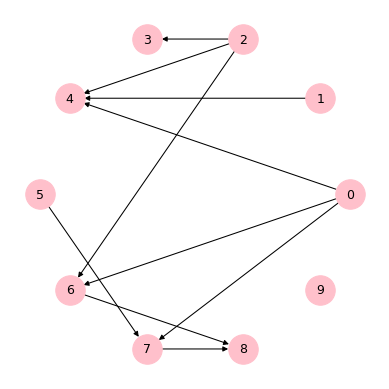


Runtime : 0.335 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Accuracy        : 0.5
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

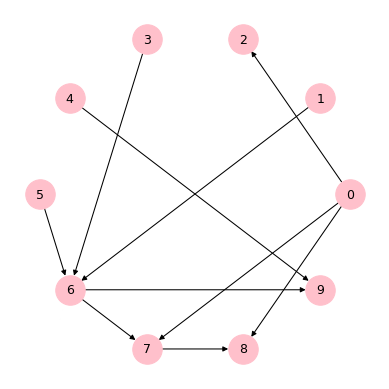


Runtime : 0.131 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
Accuracy        : 0.5
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 2 ---



array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

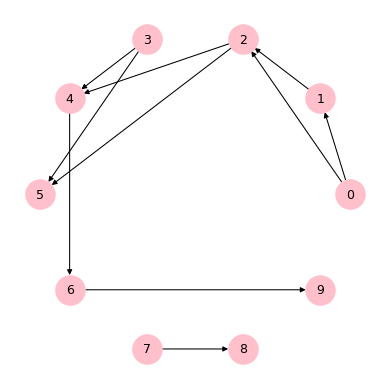


Runtime : 0.136 seconds
Predicted roots : [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Accuracy        : 0.4
F1              : 0.5
Precision       : 0.3333333333333333
Recall          : 1.0

--- 3 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

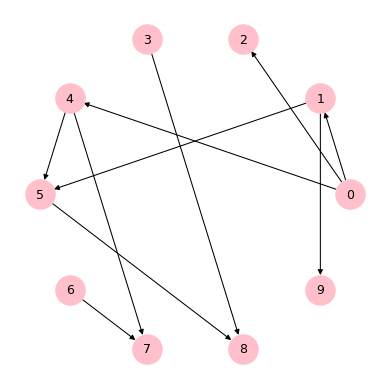


Runtime : 0.137 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Accuracy        : 0.3
F1              : 0.4615384615384615
Precision       : 0.3
Recall          : 1.0

--- 4 ---



array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

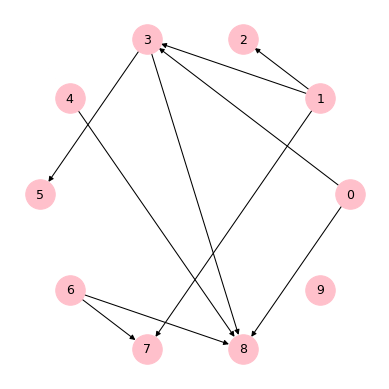


Runtime : 0.119 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Accuracy        : 0.5
F1              : 0.6666666666666666
Precision       : 0.5
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

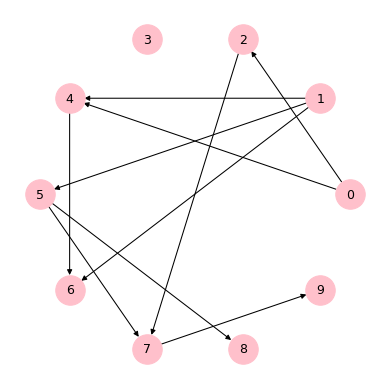


Runtime : 0.129 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
True roots      : [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 0.4
F1              : 0.5
Precision       : 0.3333333333333333
Recall          : 1.0

--- 6 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

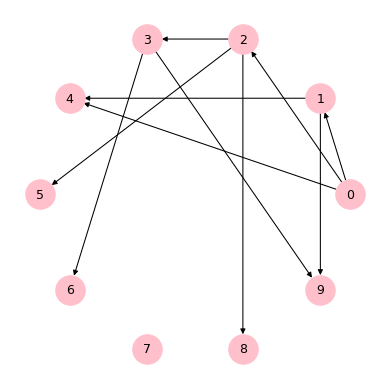


Runtime : 0.313 seconds
Predicted roots : [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
True roots      : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Accuracy        : 0.6
F1              : 0.5
Precision       : 0.3333333333333333
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

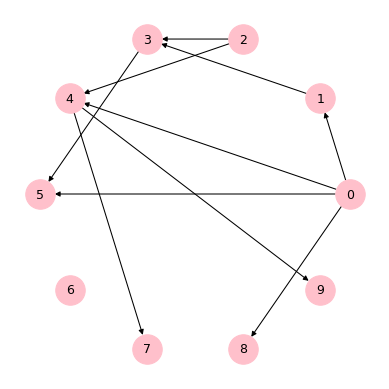


Runtime : 0.147 seconds
Predicted roots : [1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
True roots      : [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Accuracy        : 0.5
F1              : 0.5454545454545454
Precision       : 0.375
Recall          : 1.0

--- 8 ---



array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

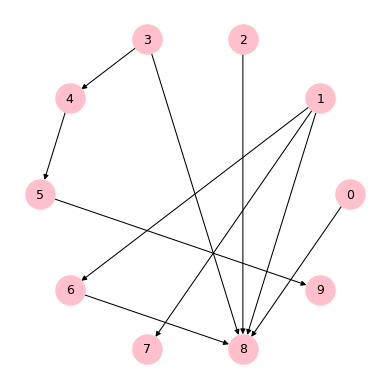


Runtime : 0.122 seconds
Predicted roots : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
True roots      : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 0.5
F1              : 0.6153846153846153
Precision       : 0.4444444444444444
Recall          : 1.0

--- 9 ---



array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

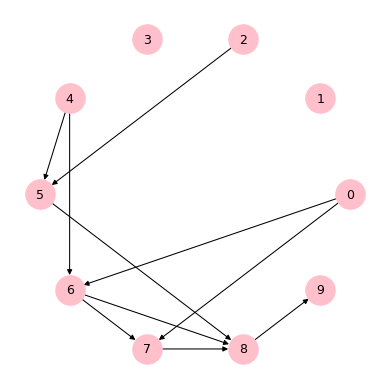


Runtime : 0.141 seconds
Predicted roots : [1, 1, 1, 1, 1, 0, 0, 1, 1, 0]
True roots      : [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.8333333333333333
Precision       : 0.7142857142857143
Recall          : 1.0

Mean accuracy  : 0.5
Mean F1        : 0.5955710955710954
Mean precision : 0.4333730158730159
Mean recall    : 1.0


In [13]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_500)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_500[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

### n = 1000


--- 0 ---



array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

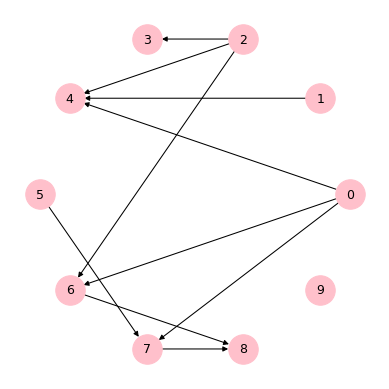


Runtime : 3.674 seconds
Predicted roots : [1, 1, 1, 0, 0, 1, 0, 0, 1, 1]
True roots      : [1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Accuracy        : 0.9
F1              : 0.9090909090909091
Precision       : 0.8333333333333334
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

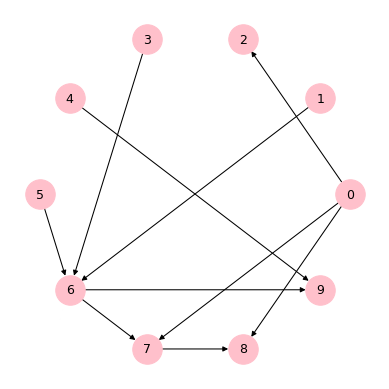


Runtime : 8.258 seconds
Predicted roots : [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
True roots      : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
Accuracy        : 0.9
F1              : 0.9090909090909091
Precision       : 0.8333333333333334
Recall          : 1.0

--- 2 ---



array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

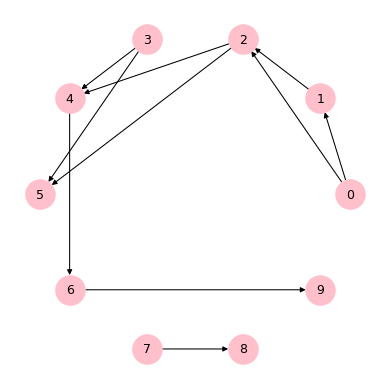


Runtime : 11.681 seconds
Predicted roots : [1, 0, 0, 1, 1, 1, 0, 1, 1, 1]
True roots      : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Accuracy        : 0.6
F1              : 0.6
Precision       : 0.42857142857142855
Recall          : 1.0

--- 3 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

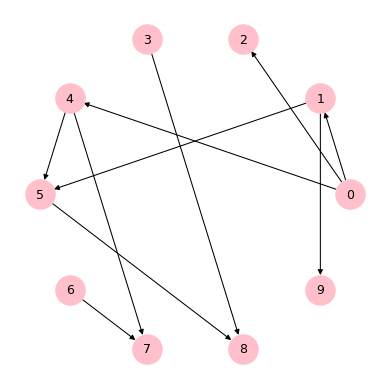


Runtime : 10.879 seconds
Predicted roots : [1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
True roots      : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Accuracy        : 0.6
F1              : 0.6
Precision       : 0.42857142857142855
Recall          : 1.0

--- 4 ---



array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

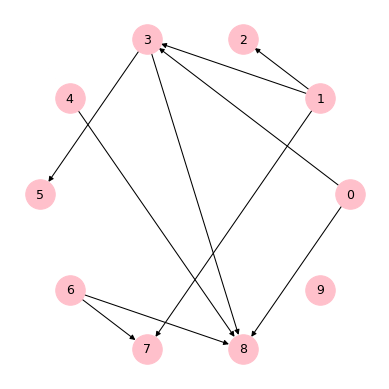


Runtime : 4.988 seconds
Predicted roots : [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
True roots      : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Accuracy        : 0.6
F1              : 0.7142857142857143
Precision       : 0.5555555555555556
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

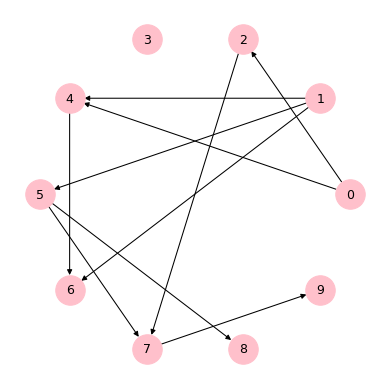


Runtime : 9.248 seconds
Predicted roots : [1, 1, 0, 1, 0, 1, 0, 0, 1, 0]
True roots      : [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.7499999999999999
Precision       : 0.6
Recall          : 1.0

--- 6 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

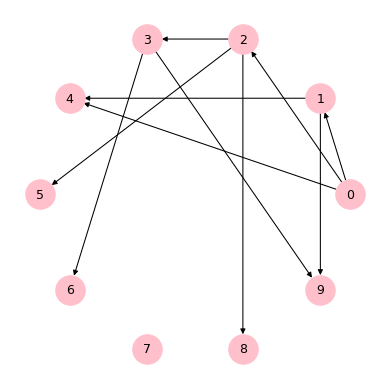


Runtime : 10.3 seconds
Predicted roots : [1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
True roots      : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Accuracy        : 0.7
F1              : 0.5714285714285715
Precision       : 0.4
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

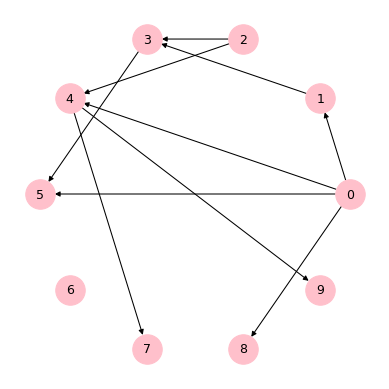


Runtime : 10.443 seconds
Predicted roots : [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]
True roots      : [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Accuracy        : 0.6
F1              : 0.6
Precision       : 0.42857142857142855
Recall          : 1.0

--- 8 ---



array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

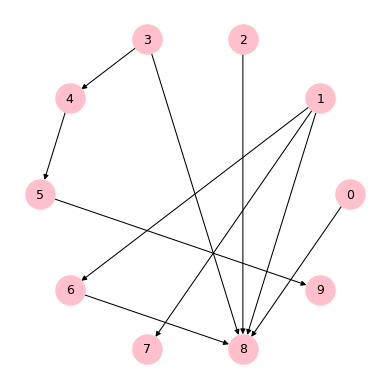


Runtime : 11.555 seconds
Predicted roots : [1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
True roots      : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 0.9
F1              : 0.888888888888889
Precision       : 0.8
Recall          : 1.0

--- 9 ---



array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

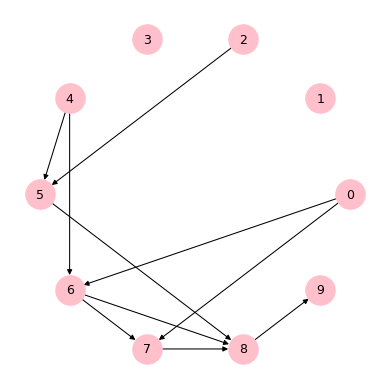


Runtime : 12.672 seconds
Predicted roots : [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
True roots      : [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy        : 0.8
F1              : 0.8333333333333333
Precision       : 0.7142857142857143
Recall          : 1.0

Mean accuracy  : 0.74
Mean F1        : 0.7376118326118326
Mean precision : 0.6022222222222222
Mean recall    : 1.0


In [14]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_1k)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_1k[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

### n = 5000


--- 0 ---



array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

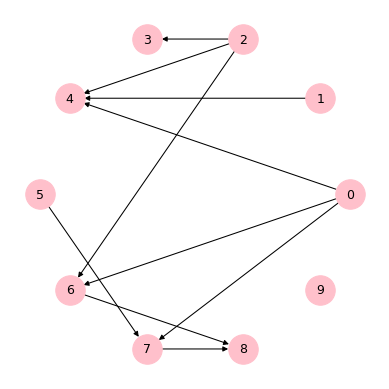


Runtime : 32.93 seconds
Predicted roots : [1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
True roots      : [1, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 1 ---



array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

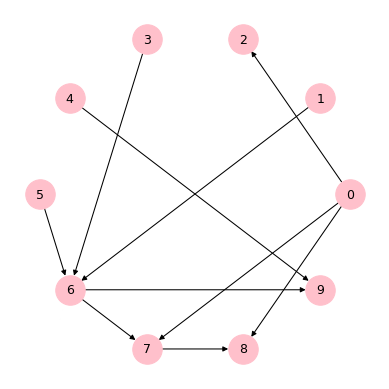


Runtime : 26.294 seconds
Predicted roots : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
True roots      : [1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 2 ---



array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

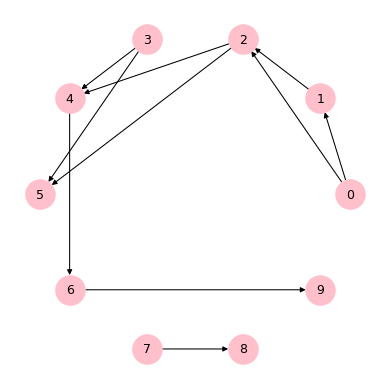


Runtime : 28.597 seconds
Predicted roots : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
True roots      : [1, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 3 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

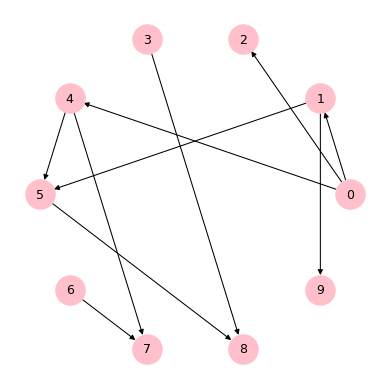


Runtime : 26.54 seconds
Predicted roots : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
True roots      : [1, 0, 0, 1, 0, 0, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 4 ---



array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

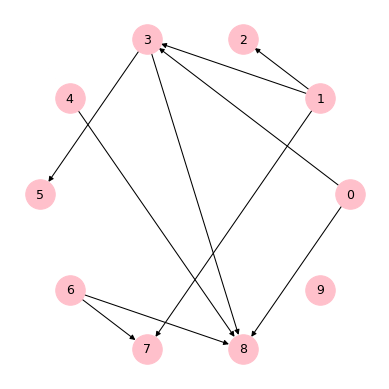


Runtime : 24.098 seconds
Predicted roots : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
True roots      : [1, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 5 ---



array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

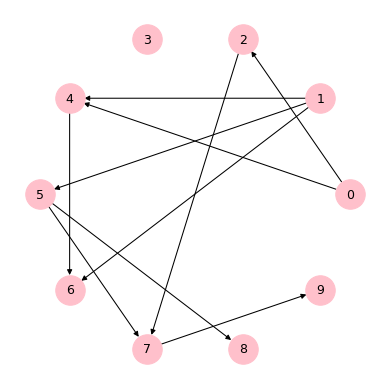


Runtime : 26.155 seconds
Predicted roots : [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
True roots      : [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 6 ---



array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

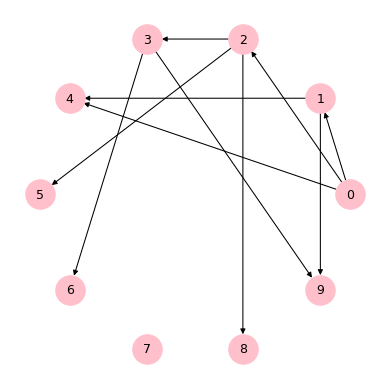


Runtime : 28.353 seconds
Predicted roots : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
True roots      : [1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 7 ---



array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

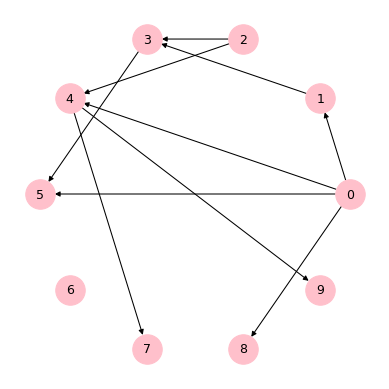


Runtime : 30.528 seconds
Predicted roots : [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
True roots      : [1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 8 ---



array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

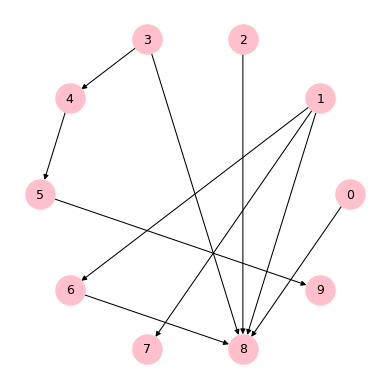


Runtime : 25.517 seconds
Predicted roots : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
True roots      : [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

--- 9 ---



array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

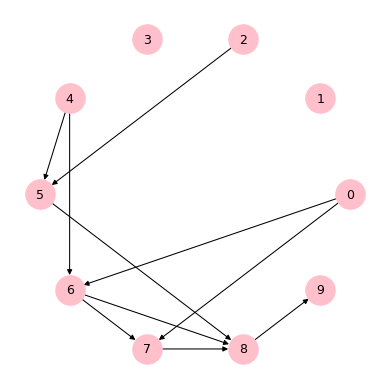


Runtime : 23.473 seconds
Predicted roots : [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
True roots      : [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy        : 1.0
F1              : 1.0
Precision       : 1.0
Recall          : 1.0

Mean accuracy  : 1.0
Mean F1        : 1.0
Mean precision : 1.0
Mean recall    : 1.0


In [15]:
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for i in range(len(samples_5k)):
    print("\n---", i, "---\n")
    display(adj_matrices[i])
    plot_nx(adj_matrices[i], labels = range(adj_matrices[i].shape[0]))

    # Run root-finding.
    start = time.time()
    roots, marg_ind = Root_Algo.root_detection(samples_5k[i], alpha = 0.001)
    print("\nRuntime :", round(time.time() - start, 3), "seconds")

    # Evaluate performance.
    true_roots = [1 if j in roots_true[i] else 0 for j in range(adj_matrices[i].shape[0])]
    pred_roots = [1 if j in roots else 0 for j in range(adj_matrices[i].shape[0])]
    accuracy = accuracy_score(true_roots, pred_roots)
    accuracy_scores.append(accuracy)
    f1 = f1_score(true_roots, pred_roots)
    f1_scores.append(f1)
    precision = precision_score(true_roots, pred_roots)
    precision_scores.append(precision)
    recall = recall_score(true_roots, pred_roots)
    recall_scores.append(recall)
    
    print("Predicted roots :", pred_roots)
    print("True roots      :", true_roots)
    print("Accuracy        :", accuracy)
    print("F1              :", f1)
    print("Precision       :", precision)
    print("Recall          :", recall)

print("\nMean accuracy  :", np.mean(accuracy_scores))
print("Mean F1        :", np.mean(f1_scores))
print("Mean precision :", np.mean(precision_scores))
print("Mean recall    :", np.mean(recall_scores))

## Edge pruning

In [16]:
parents_correct_total = 0
children_correct_total = 0

for i in range(len(samples_500)):
    print("\n---", i, "---\n")
    graph = graphs[i]
    data = samples_500[i]
    adj = adj_matrices[i]
    true_sort = list(nx.topological_sort(graph))
    ed = EdgeDiscovery(adjacency_matrix = adj)
    start = time.time()
    pred_parents, pred_children = ed.path_tracing(true_sort, 
                                                  data, 
                                                  cit_test = "oracle", 
                                                  alpha = 0.01)
    print("Edge discovery complete in {}s.".format(round(time.time() - start, 4)))

    true_parents_sets = []
    true_children_sets = []
    for j in range(adj.shape[0]):
        true_parents = set(np.where(adj[:,j] == 1)[0])
        true_parents_sets.append(true_parents)
        true_children = set(np.where(adj[j,:] == 1)[0])
        true_children_sets.append(true_children)

    parents_correct = all([x == y for x,y in zip(true_parents_sets,pred_parents)])
    parents_correct_total += parents_correct
    children_correct = all([x == y for x,y in zip(true_children_sets,pred_children)])
    children_correct_total += children_correct

    print("True parents       :", true_parents_sets)
    print("Predicted parents  :", pred_parents)
    print("Parents correct    :", parents_correct)
    print("True children      :", true_children_sets)
    print("Predicted children :", pred_children)
    print("Children correct   :", children_correct)

print("\nFraction parents correct  :", parents_correct_total / len(adj_matrices))
print("Fraction children correct :", children_correct_total / len(adj_matrices))


--- 0 ---

Edge discovery complete in 0.0146s.
True parents       : [set(), set(), set(), {2}, {0, 1, 2}, set(), {0, 2}, {0, 5}, {6, 7}, set()]
Predicted parents  : [set(), set(), set(), {2}, {0, 1, 2}, set(), {0, 2}, {0, 5}, {6, 7}, set()]
Parents correct    : True
True children      : [{4, 6, 7}, {4}, {3, 4, 6}, set(), set(), {7}, {8}, {8}, set(), set()]
Predicted children : [{4, 6, 7}, {4}, {3, 4, 6}, set(), set(), {7}, {8}, {8}, set(), set()]
Children correct   : True

--- 1 ---

Edge discovery complete in 0.0063s.
True parents       : [set(), set(), {0}, set(), set(), set(), {1, 3, 5}, {0, 6}, {0, 7}, {4, 6}]
Predicted parents  : [set(), set(), {0}, set(), set(), set(), {1, 3, 5}, {0, 6}, {0, 6, 7}, {4, 6}]
Parents correct    : False
True children      : [{8, 2, 7}, {6}, set(), {6}, {9}, {6}, {9, 7}, {8}, set(), set()]
Predicted children : [{8, 2, 7}, {6}, set(), {6}, {9}, {6}, {8, 9, 7}, {8}, set(), set()]
Children correct   : False

--- 2 ---

Edge discovery complete in 0.006s.

In [17]:
for g in graphs:
    print(nx.is_directed_acyclic_graph(g))

True
True
True
True
True
True
True
True
True
True


## End of document